2.194924600624181 9.700955537517649
156868
lambda = 0.0580


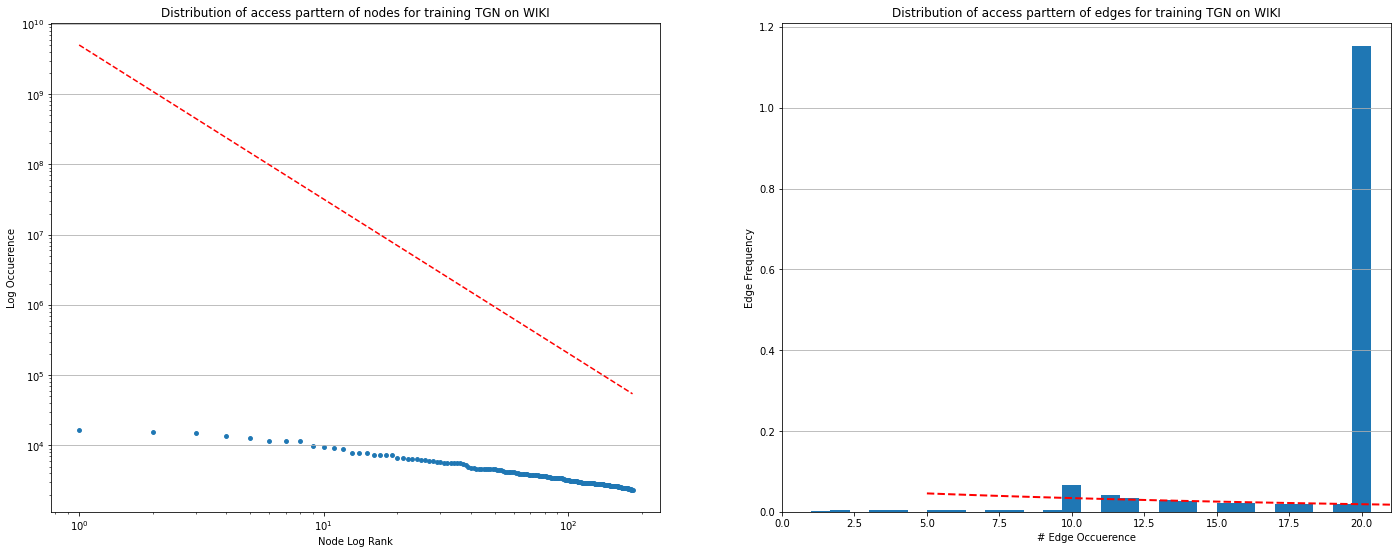

1.0339962298019965 6.145550190309489
662447
lambda = 0.1202


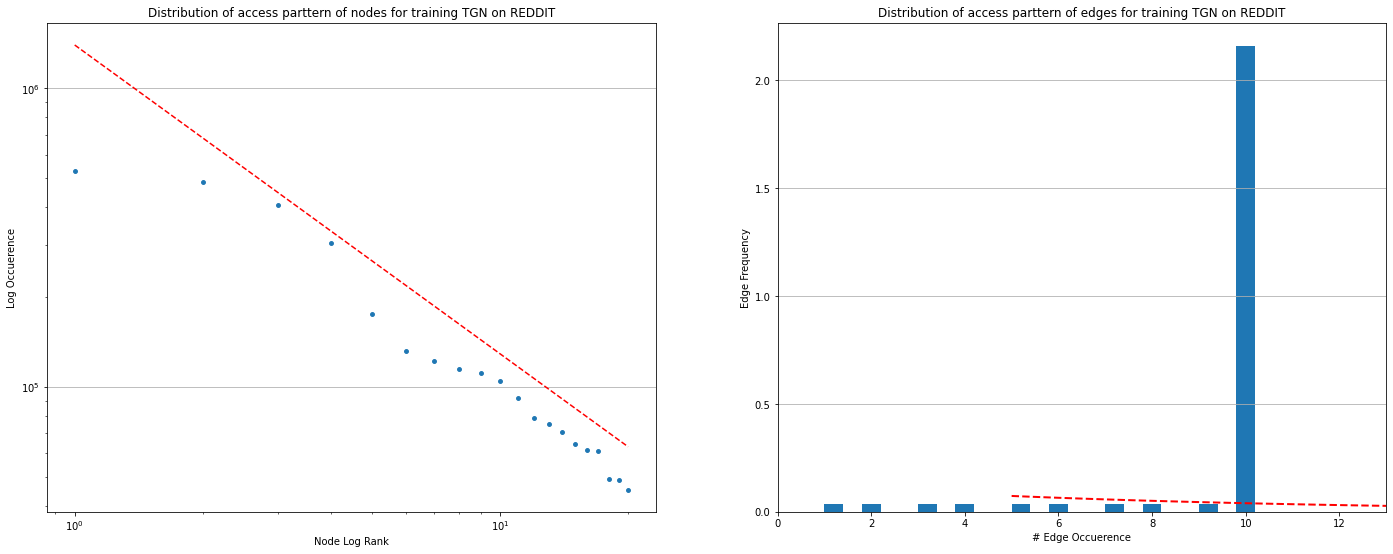

11.132541397634162 63.085319012288316
404674
lambda = 0.0564


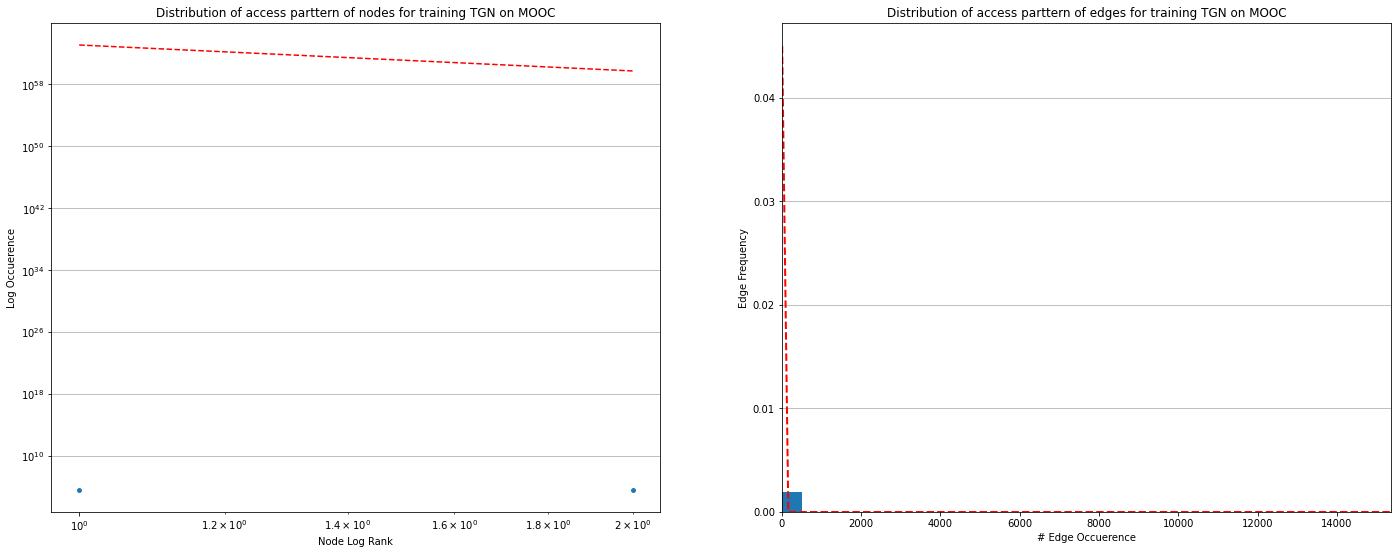

7.292441827266328 33.64265935221442
1291806
lambda = 0.1115


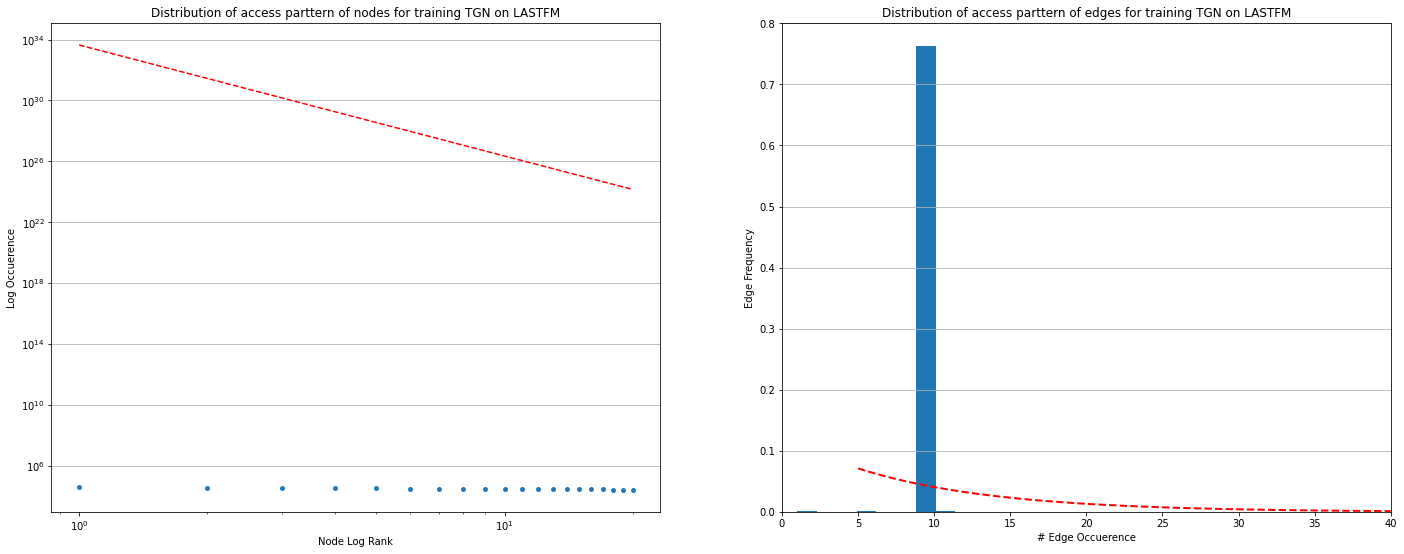

2.1678152784422053 11.885914031881542
154404
lambda = 0.0052


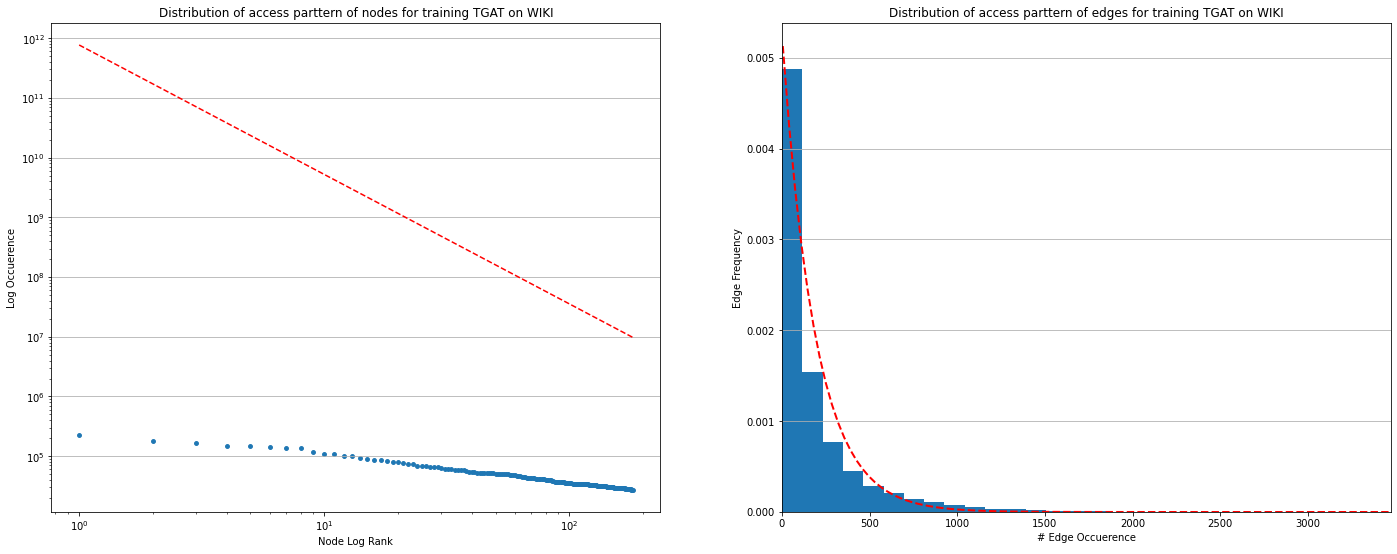

1.039531145734537 6.488874497848526
635363
lambda = 0.0542


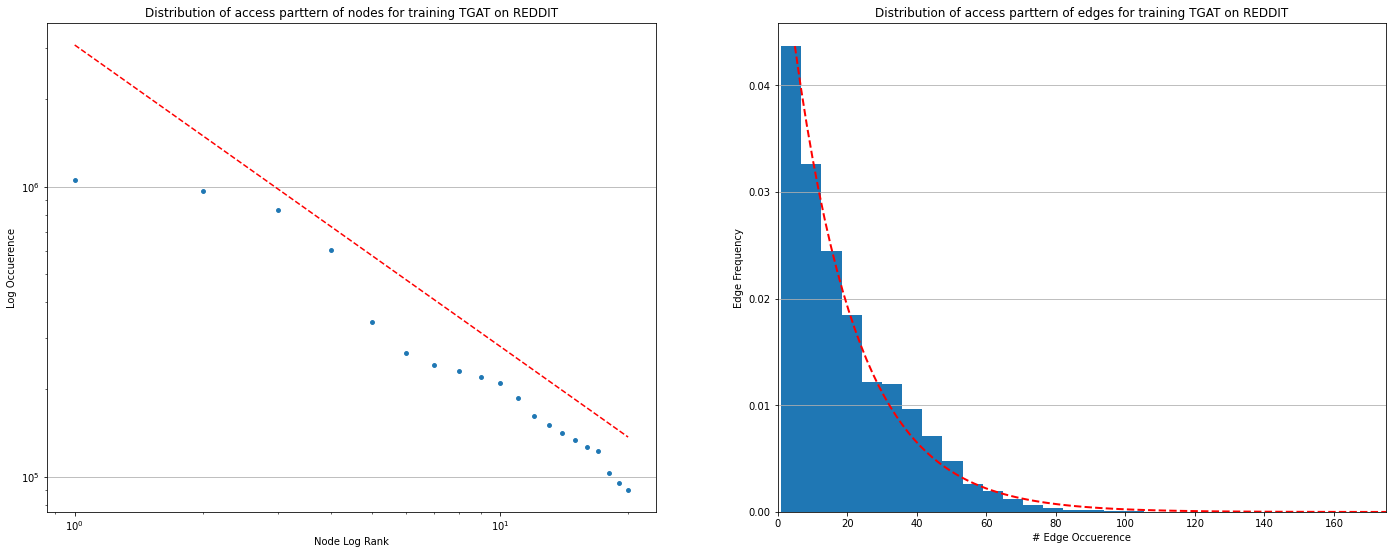

2.517550858477213 17.472153657152745
388485
lambda = 0.0050


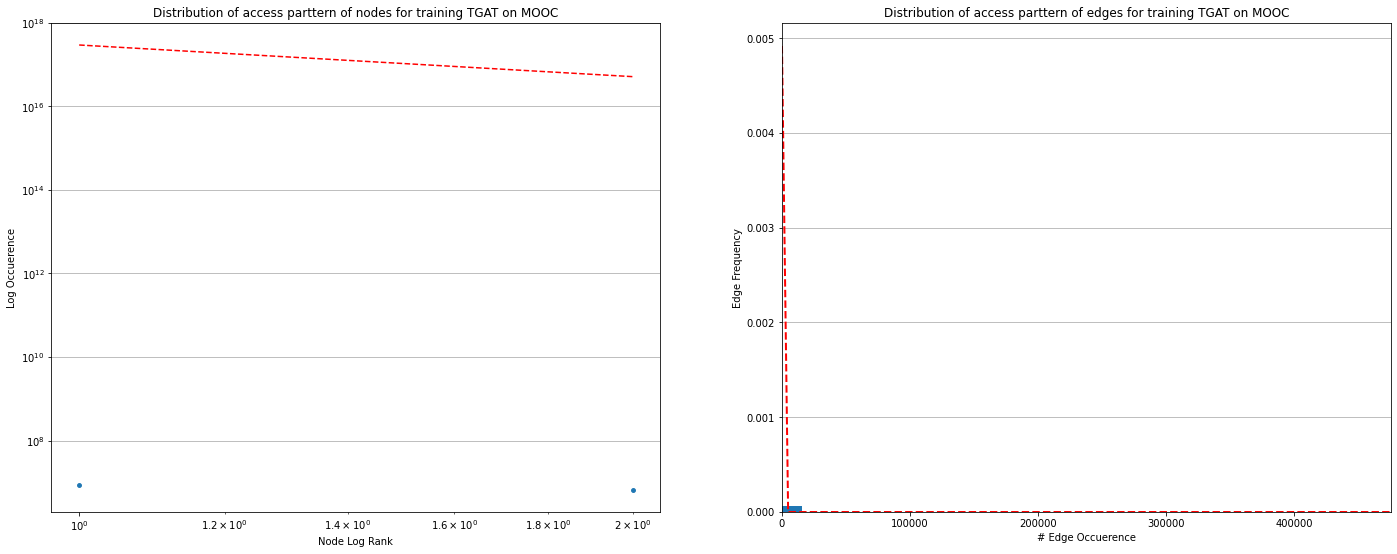

7.558576887807686 37.400387501360306
1230526
lambda = 0.0502


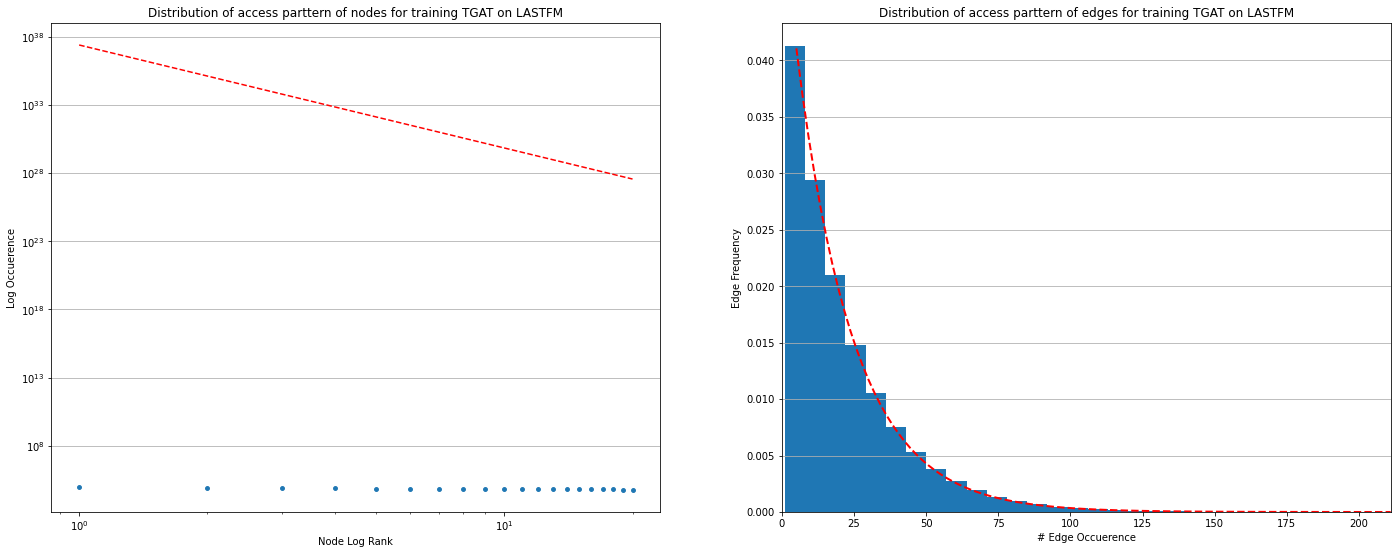

1.766438375238783 10.025048813627874
146622
lambda = 0.0064


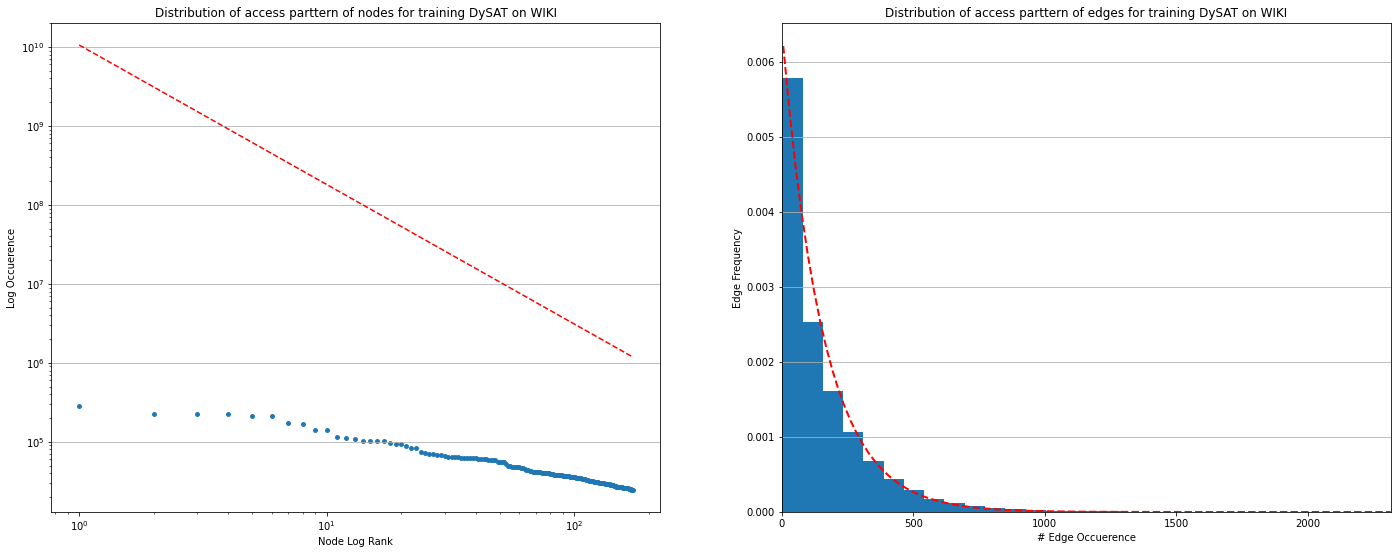

1.0064070334545843 5.989754648663131
470867
lambda = 0.0991


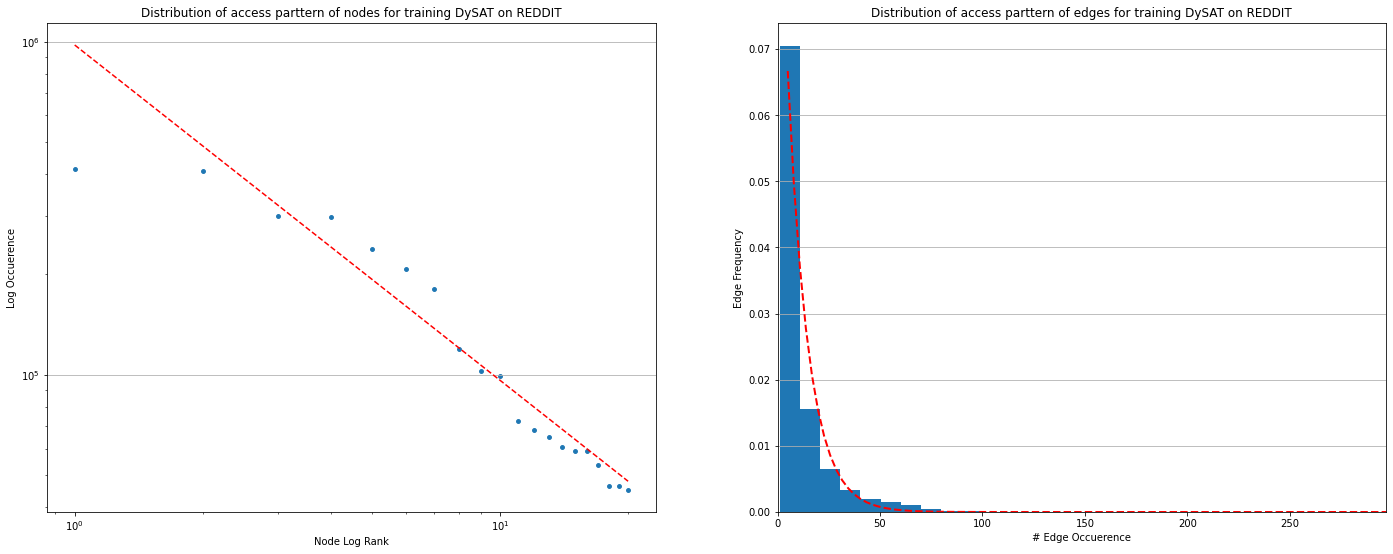

7.175159218710146 40.35949828003424
370693
lambda = 0.0459


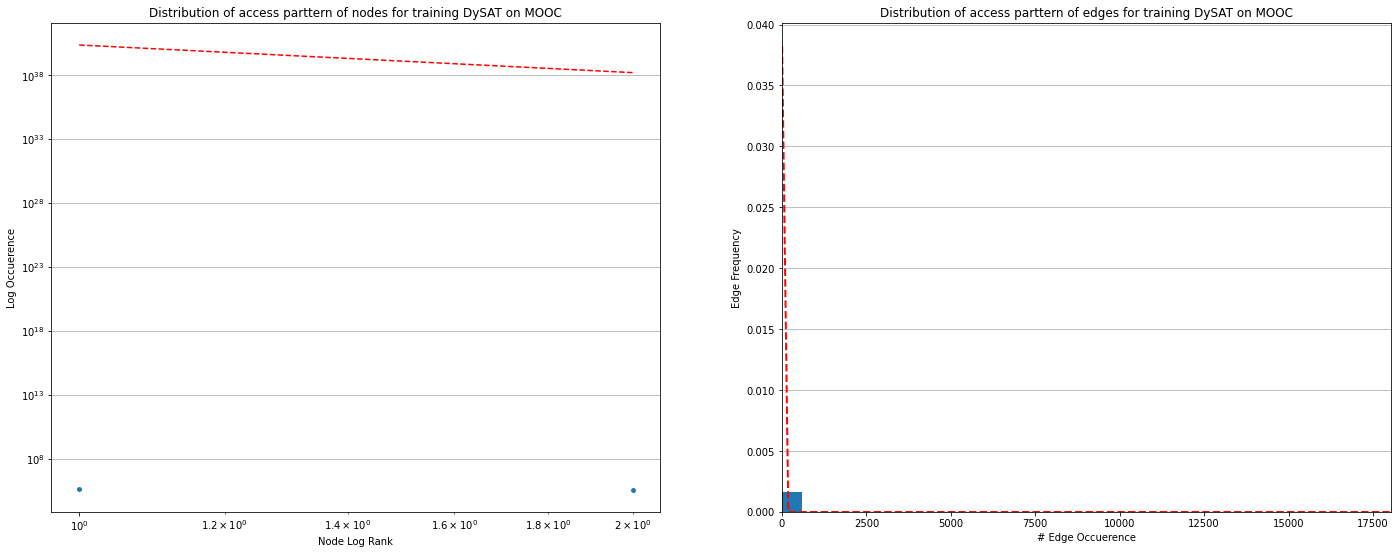

4.367323662295607 22.51180552356947
1074763
lambda = 0.0607


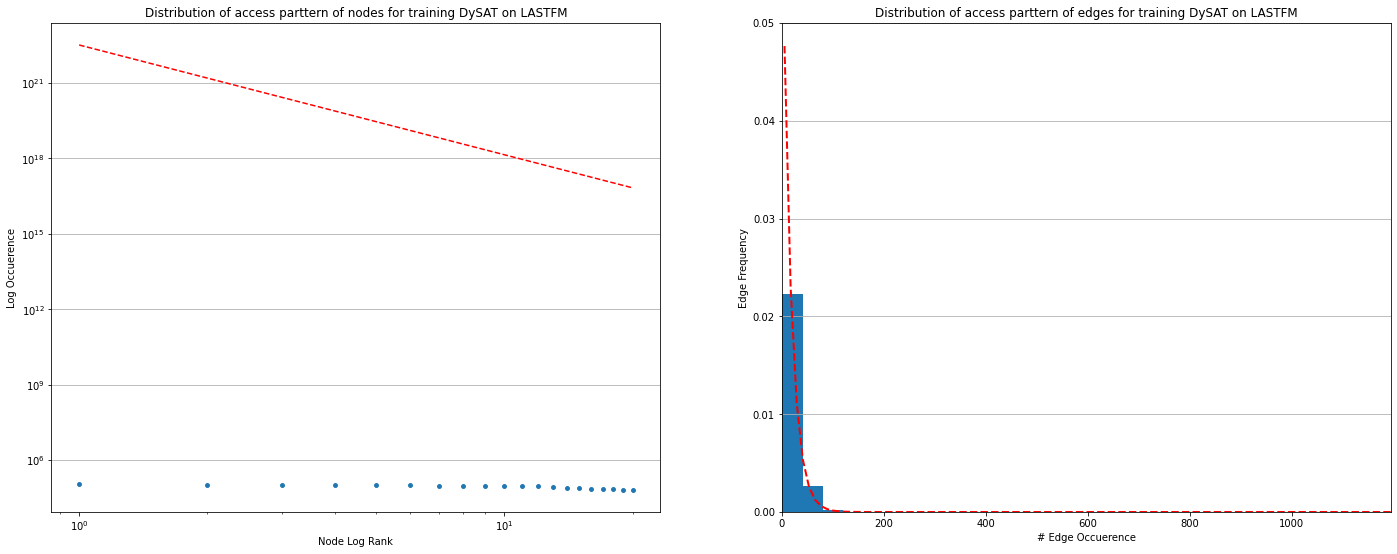

2.1944391473405656 12.425055755361722
157474
lambda = 0.0034


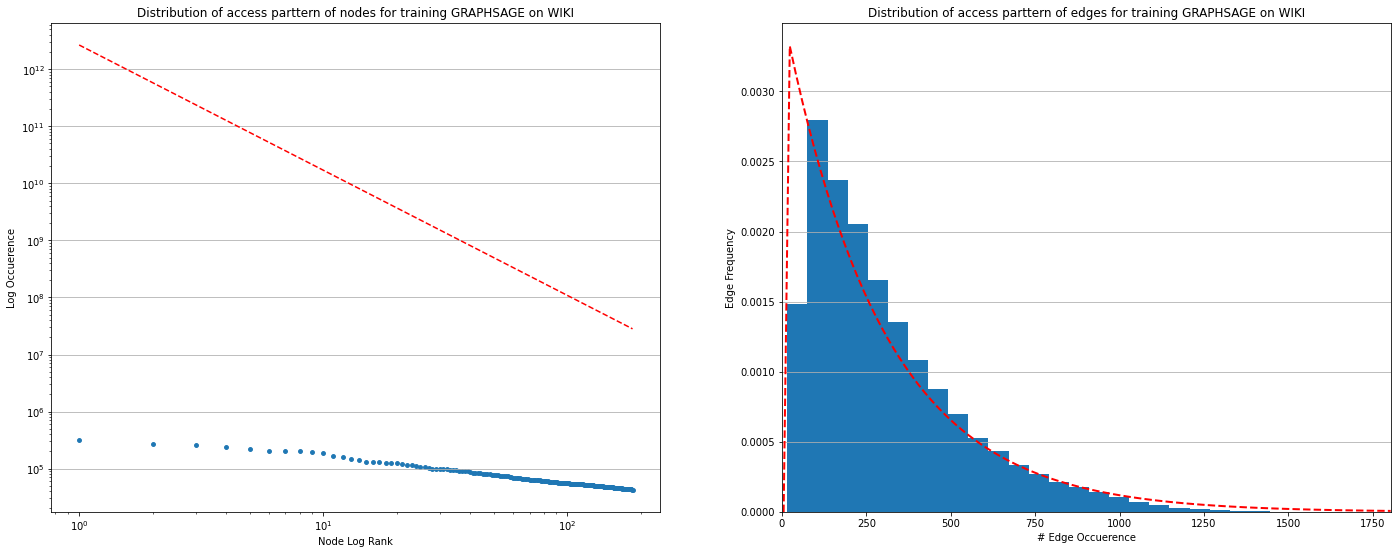

1.0312571148712886 6.575990831570934
672447
lambda = 0.0500


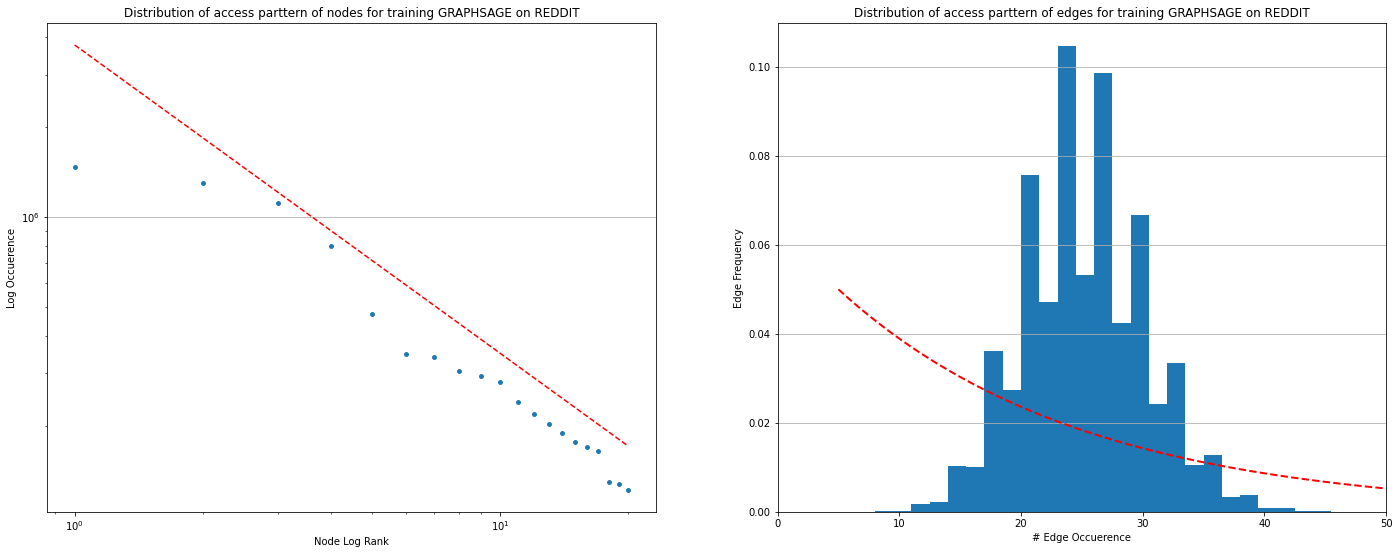

4.938975941280697 34.783178888471944
411749
lambda = 0.0033


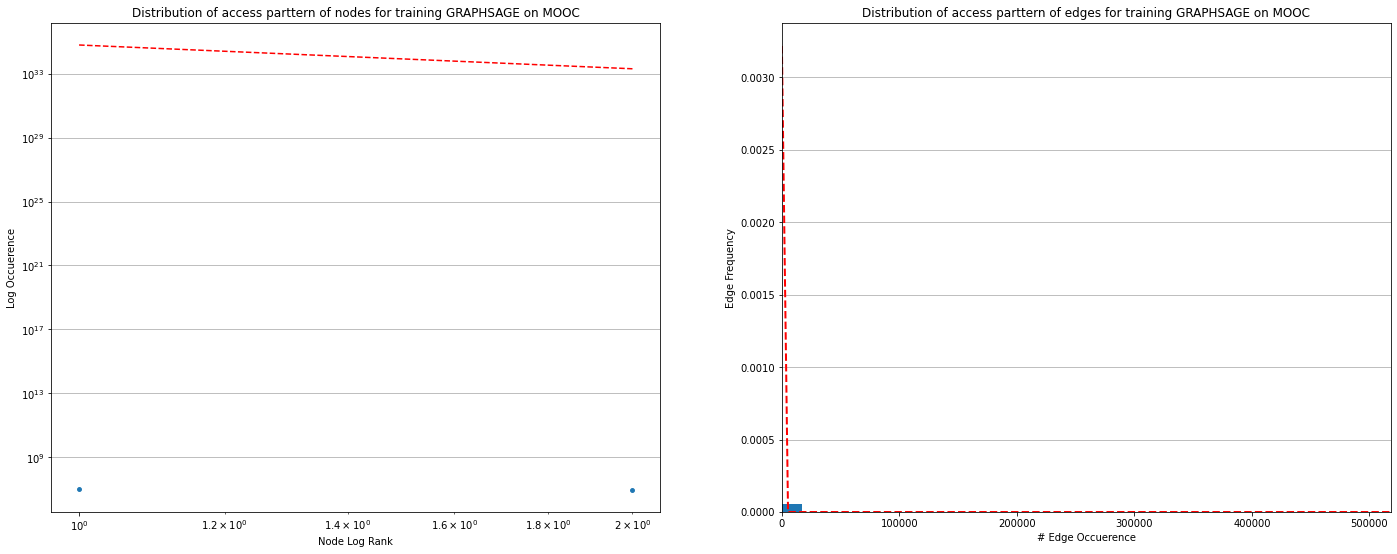

7.231760658170595 36.26029650150593
1293103
lambda = 0.0435


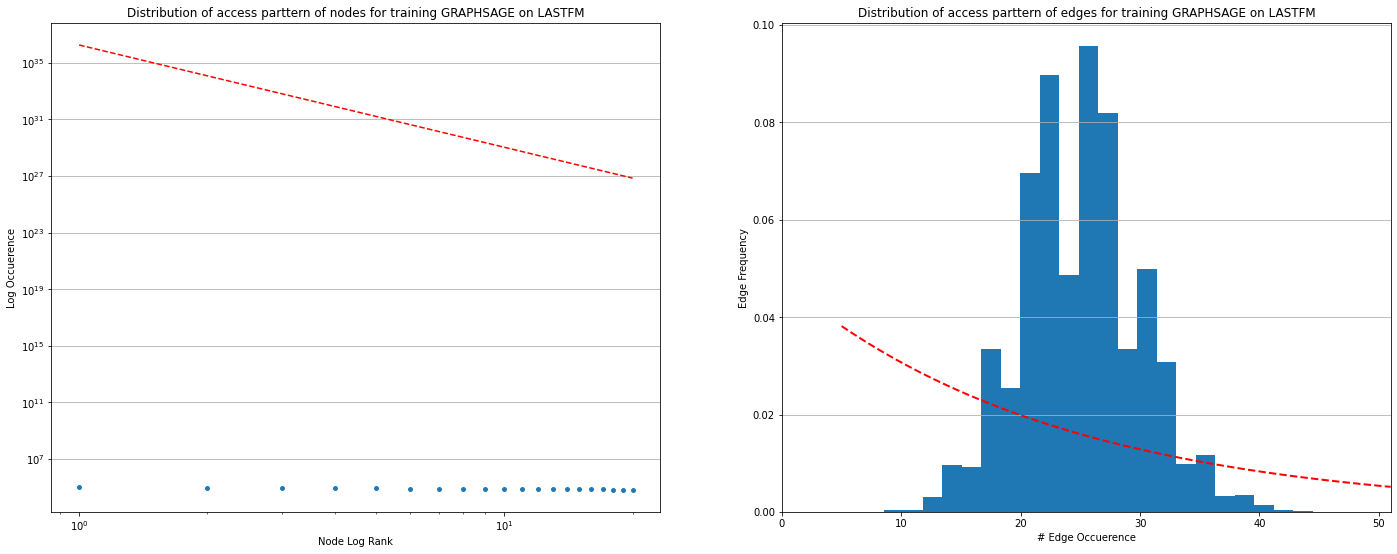

2.192169388982256 12.059646023276436
157474
lambda = 0.0050


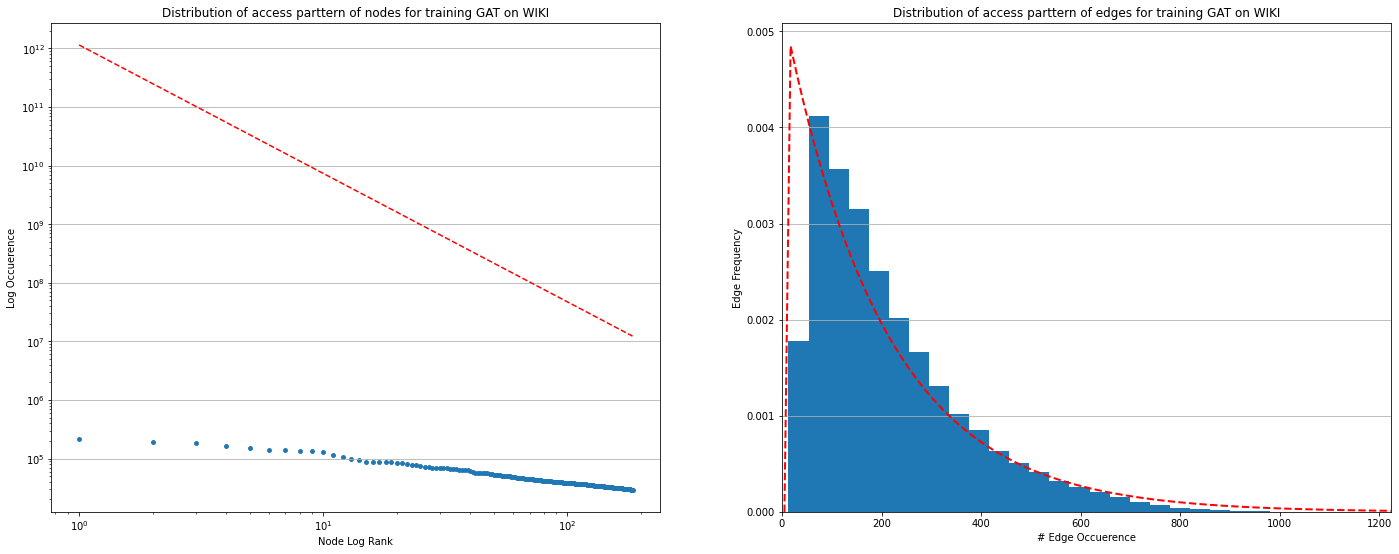

1.0315199678876832 6.477509300234847
672447
lambda = 0.0588


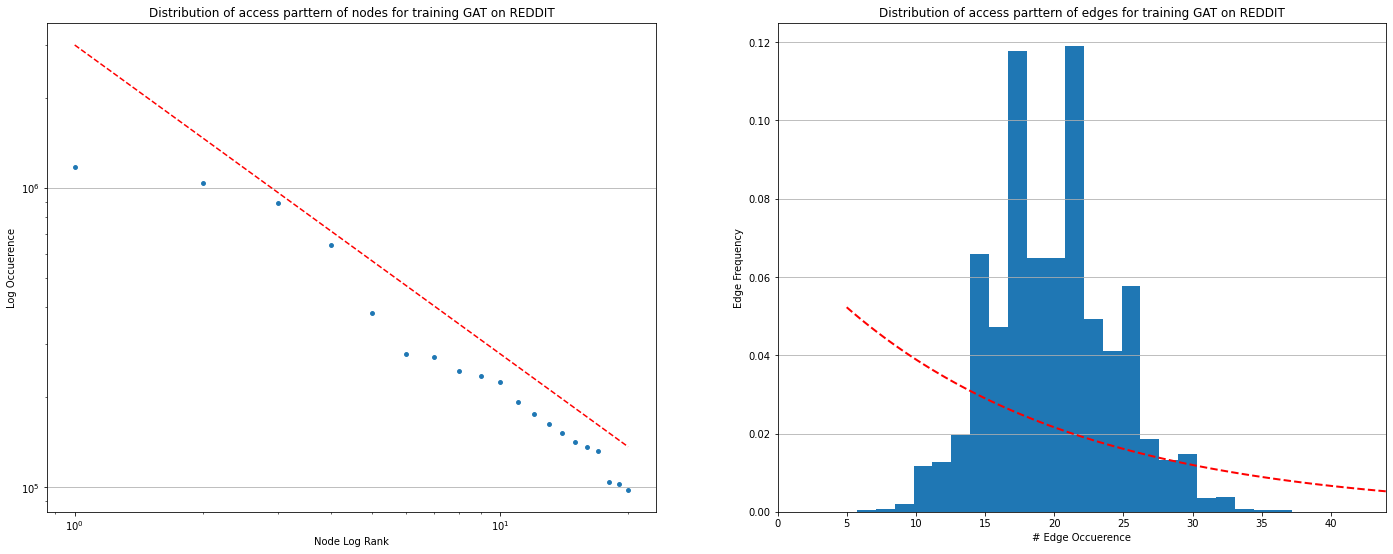

4.878459851156865 33.57673682277646
411749
lambda = 0.0047


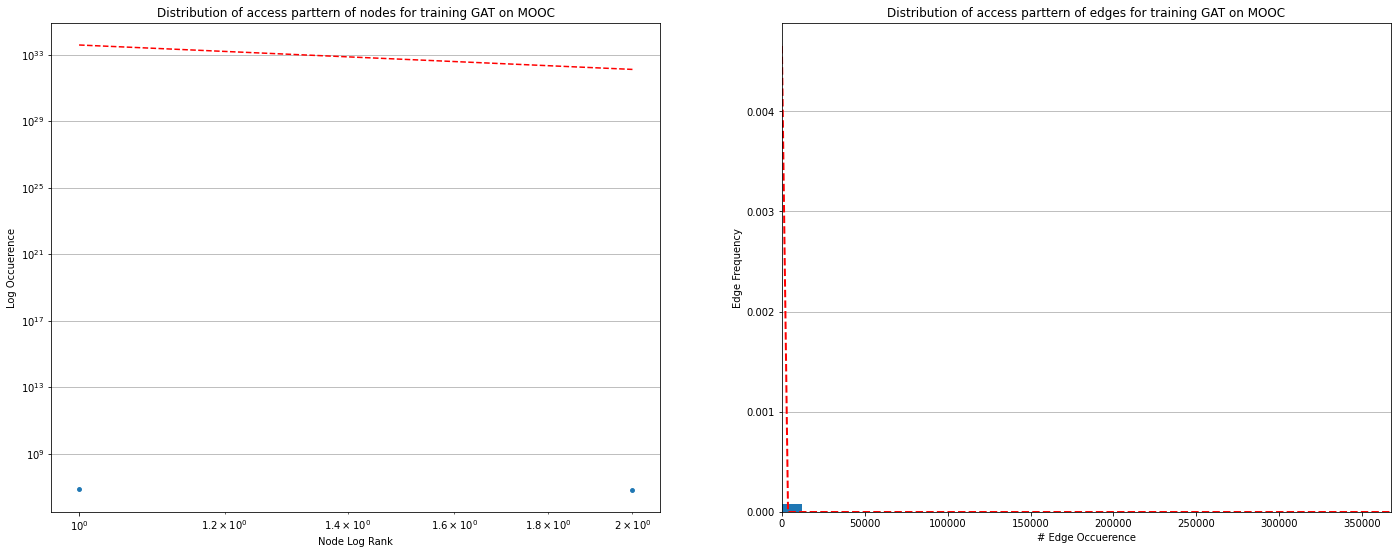

7.32302967293806 35.99661052464982
1293103
lambda = 0.0556


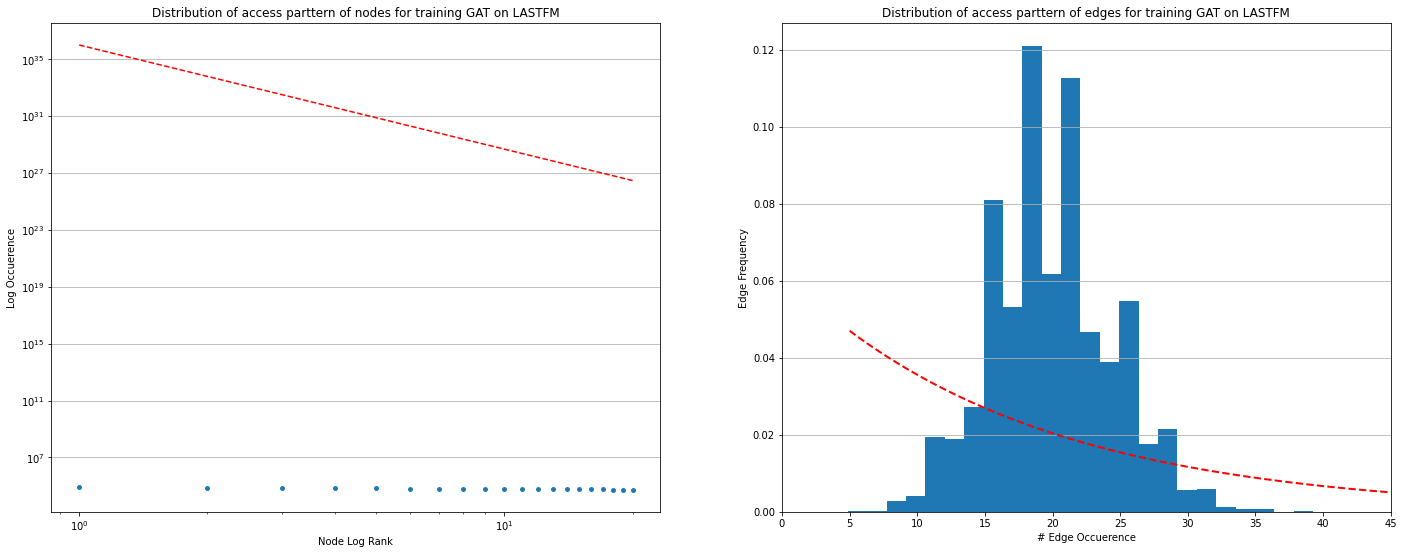

In [104]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import expon
import itertools
import pickle

model = 'TGAT'
dataset = 'REDDIT'

models = ['TGN', 'TGAT', 'DySAT', 'GRAPHSAGE', 'GAT']
datasets = ['WIKI', 'REDDIT', 'MOOC', 'LASTFM']

param_space = itertools.product(
    models, datasets)

for param in param_space:
    with open("{}_{}_node_to_cnt.pickle".format(*param), 'rb') as f:
        node_to_cnt = pickle.load(f)
    with open("{}_{}_edge_to_cnt.pickle".format(*param), 'rb') as f:
        edge_to_cnt = pickle.load(f)

    def log_rank_freq(d, ax, type):
        values = sorted(d.values(), reverse=True)
        cutoff = np.percentile(values, 98)
        values = [v for v in values if v > cutoff]
        ranks = range(1, len(values)+1)

        x = np.log10(values)
        y = np.log10(ranks)
        
        coeffs = np.polyfit(x, y, 1)
        alpha = -coeffs[0]
        C = 10**coeffs[1]
        print(alpha, coeffs[1])

        ax.scatter(ranks, values, s=15)

        x = np.logspace(np.log10(ranks[0]), np.log10(ranks[-1]), num=len(ranks))
        y = C * x**(-alpha) 
        ax.loglog(x, y, linestyle='--', color='r')
        ax.grid(axis='y')
        ax.set_xlabel("Node Log Rank")
        ax.set_ylabel("Log Occuerence")
        ax.set_title("Distribution of access parttern of nodes for training {} on {}".format(*param))

    def hist(d, ax, type):
        data = list(d.values())
        print(len(data))
        ax.hist(data, bins=30, density=True)
        ax.set_xlabel('# {} Occuerence'.format(type))
        ax.set_ylabel('{} Frequency'.format(type))
        ax.set_xlim((0, max(data)))
        ax.grid(axis='y')
        
        # 拟合指数分布
        loc, scale = expon.fit(data)
        pdf = expon.pdf(np.linspace(5, max(data), 100), loc, scale)
        ax.plot(np.linspace(5, max(data), 100), pdf, 'r--', linewidth=2)
        print("lambda = {:.4f}".format(1/scale))
        ax.set_title("Distribution of access parttern of edges for training {} on {}".format(*param))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(24, 9)
    log_rank_freq(node_to_cnt, ax1, 'Node')
    hist(edge_to_cnt, ax2, 'Edge')

    plt.show()